In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import Torch

In [2]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [3]:
#set up device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import requests
import zipfile
from pathlib import Path

#path to folder
data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print('directory exists')
else:
    print('Creating one....')
    image_path.mkdir(parents=True,exist_ok=True)

    with open(data_path/'pizza_steak_sushi.zip','wb') as f :
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r')as zip_ref:
        zip_ref.extractall(image_path)
        

    

Creating one....


In [5]:
import os 
def walk_through(image_path):
    for dirpath,dirnames,filenames in os.walk(image_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
walk_through(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [7]:
#setup training and testing path
train_dir = image_path/'train'
test_dir = image_path/'test'
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

VISUALIZE

Random image path: data/pizza_steak_sushi/test/sushi/175783.jpg
Image class: sushi
Image height: 382
Image width: 512


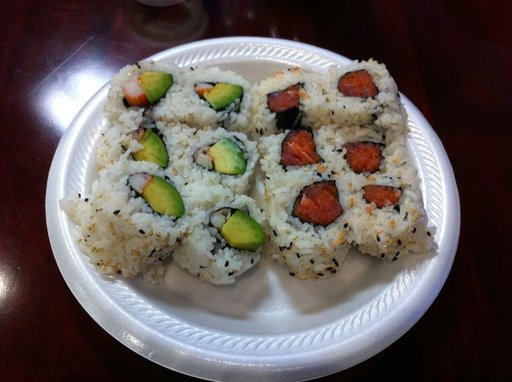

In [8]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

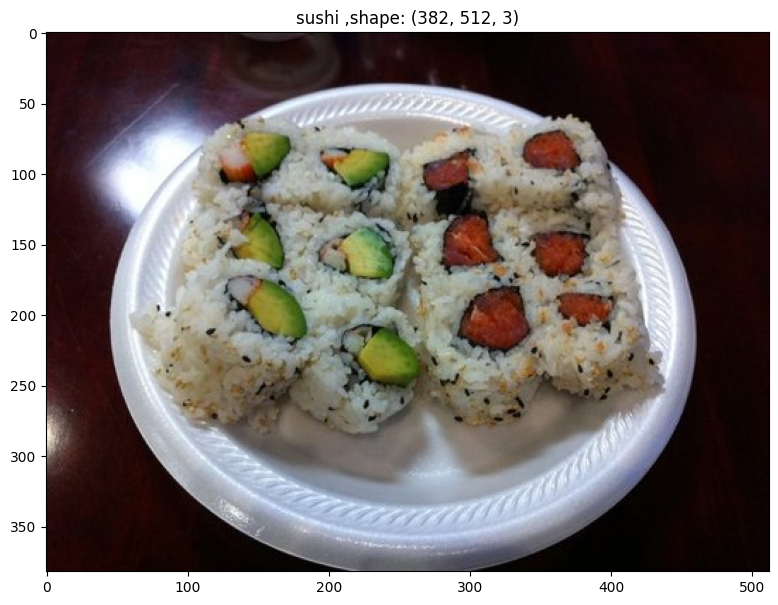

In [9]:
#use matplotlib
import numpy as np
import matplotlib.pyplot as plt

imgarray = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(imgarray)
plt.title(f'{image_class} ,shape: {imgarray.shape}')
plt.show()


Transforming img

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

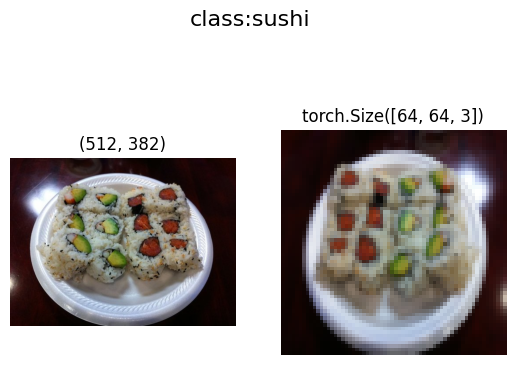

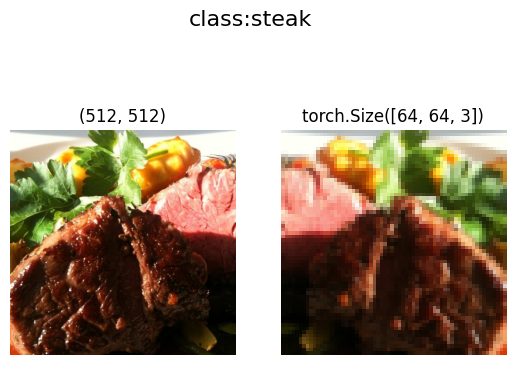

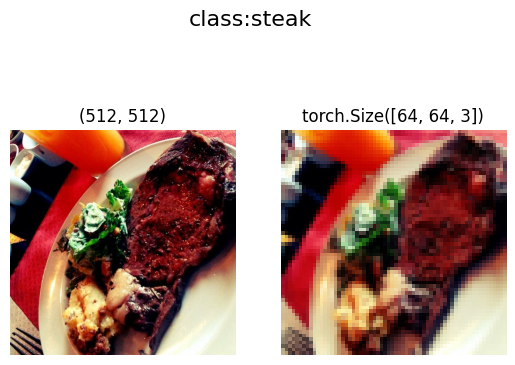

In [12]:
def plot(image_paths,transform,n=3,seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f :
            fig,ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f.size)
            ax[0].axis('off')
            

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(transformed_image.shape)
            ax[1].axis('off')
            fig.suptitle(f'class:{image_path.parent.stem}',fontsize=16)
plot(image_path_list,transform=transform,n=3)            

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [17]:
img,label = train_data[0][0],train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Text(0.5, 1.0, 'pizza')

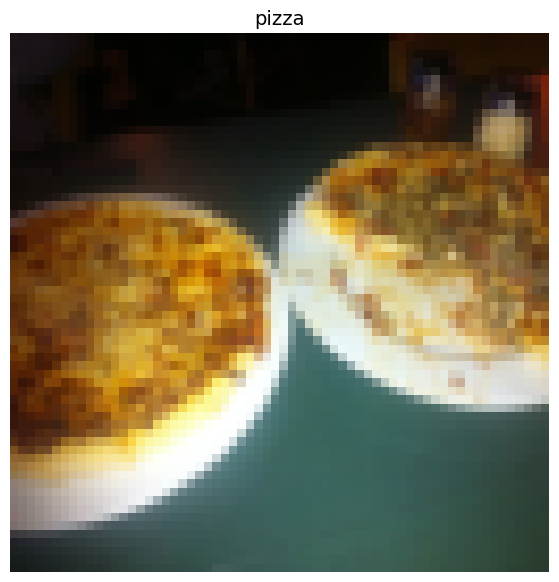

In [18]:
img_permute = img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label],fontsize=14)

In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78f3d2adc490>,
 <torch.utils.data.dataloader.DataLoader at 0x78f3bba60490>)

In [20]:
img,label = next(iter(train_dataloader))
print(img.shape),print(label.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1])


(None, None)

WRITING YOUR OWN DATASET

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
target_directory = train_dir
print(f'Target directory: {target_directory}')

class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found


Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
#function
def find_class(directory):
    class_names = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())
    if not class_names:
        raise FileNotFoundError(f'not found')
    class_to_idx =  {item:idx for idx,item in enumerate(class_names)}   
    return class_names,class_to_idx
find_class(target_directory)    

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
class customDataset(Dataset):
    def __init__(self,targ_directory,transform=None):
        self.paths= list(pathlib.Path(targ_directory).glob('*/*.jpg'))
        self.transform = transform
        self.classes,self.class_to_idx = find_class(targ_directory)

    def load_image(self,index:int):
        image_path = self.paths[index]
        return Image.open(image_path)
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index:int):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img),class_idx
        else:
            return img,class_idx

In [25]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [26]:
train_data_custom = customDataset(targ_directory=train_dir, 
                                      transform=train_transforms)
test_data_custom = customDataset(targ_directory=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.customDataset at 0x78f3bb8df100>,
 <__main__.customDataset at 0x78f3bc34e4d0>)

In [27]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [28]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [29]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [30]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [31]:
def display(dataset,classes=None,n=10,display_shape=True,seed=None):
    if n > 10: 
        display_shape=False
        print('n should be <=10')

    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)),k=n)
    plt.figure(figsize=(20,20))

    for i,tg_sam in enumerate(random_samples_idx):
        img,label = dataset[tg_sam][0],dataset[tg_sam][1]
        tg_image_adjus= img.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(tg_image_adjus)
        if classes:
            title = f'class:{classes[label]}'
            if display_shape:
                title = title + f'\nshape:{tg_image_adjus.shape}'
        plt.title(title)        

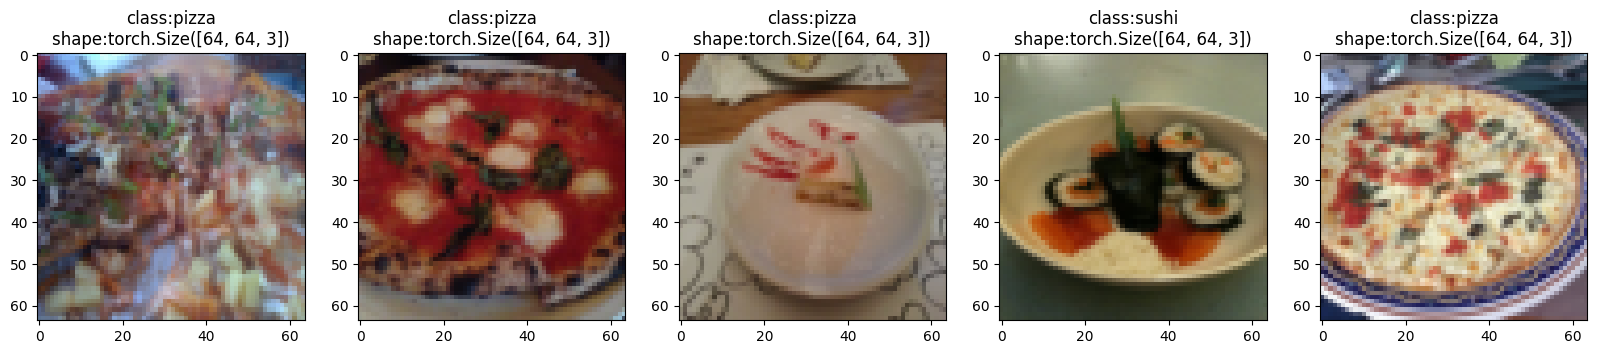

In [32]:
# Display random images from ImageFolder created Dataset
display(train_data, 
        n=5, 
        #display_shape=True,
        classes=class_names,
        seed=None)

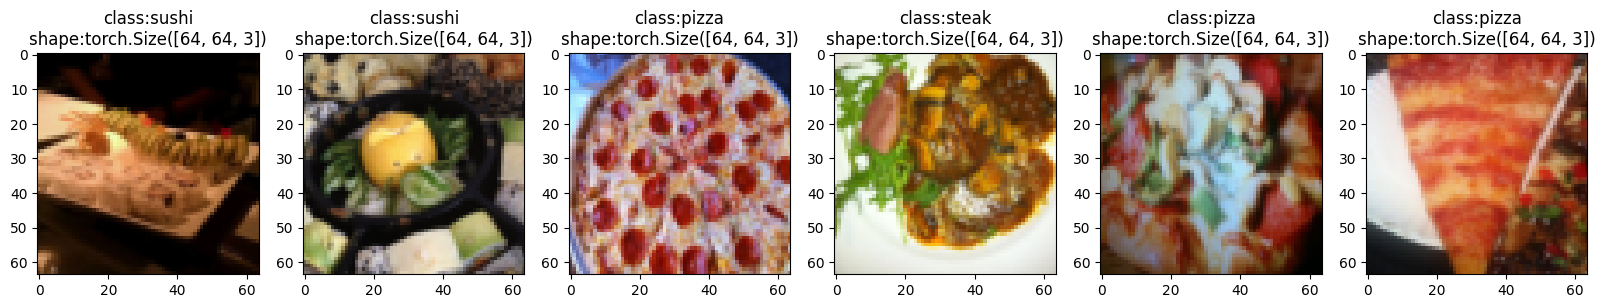

In [33]:
# Display random images from ImageFolderCustom Dataset
display(train_data_custom, 
                      n=6, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

In [34]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78f3b93026b0>,
 <torch.utils.data.dataloader.DataLoader at 0x78f3ba03faf0>)

In [35]:
img,label = next(iter(train_dataloader_custom))
img.shape,label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [36]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [37]:
image_paths = list(image_path.glob('*/*/*.jpg'))
image_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg')]

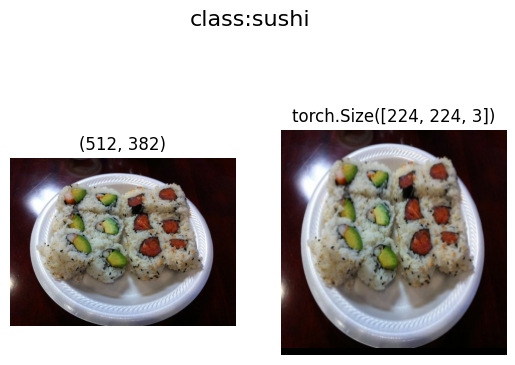

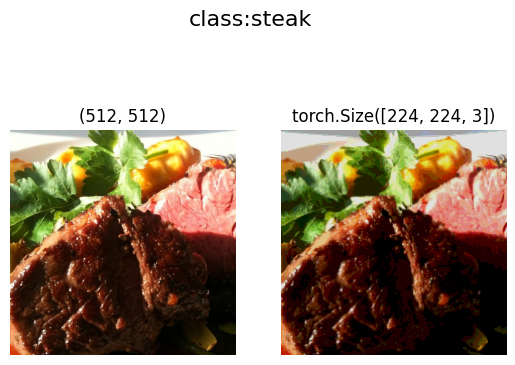

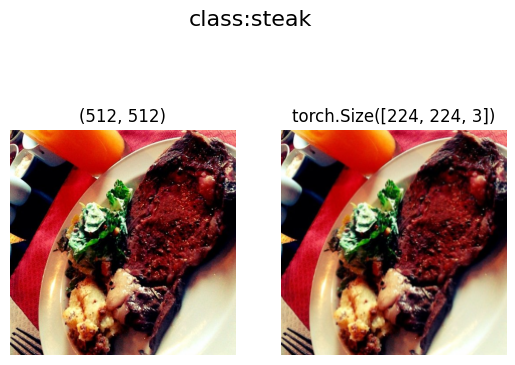

In [38]:
plot(image_paths,train_transforms,n=3,seed=42)

In [39]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
train_dataset = datasets.ImageFolder(train_dir,
                                    simple_transform)
test_dataset = datasets.ImageFolder(test_dir,
                                    simple_transform)

#dataloader
train_dataloader= DataLoader(train_dataset,
                           num_workers=1,
                           batch_size=32,
                           shuffle=True)
test_dataloader= DataLoader(test_dataset,
                           num_workers=1,
                           batch_size=32,
                           shuffle=True)

In [41]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [42]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [43]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [44]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [45]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [46]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1166 | test_acc: 0.3002
Epoch: 2 | train_loss: 1.1197 | train_acc: 0.3164 | test_loss: 1.1194 | test_acc: 0.2775
Epoch: 3 | train_loss: 1.0950 | train_acc: 0.4141 | test_loss: 1.1048 | test_acc: 0.2576
Epoch: 4 | train_loss: 1.1113 | train_acc: 0.2930 | test_loss: 1.1030 | test_acc: 0.2775
Epoch: 5 | train_loss: 1.0954 | train_acc: 0.4141 | test_loss: 1.1052 | test_acc: 0.2576
Total training time: 5.332 seconds


In [47]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [48]:
def plot_loss(results):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))
    
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss,label='test_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy,label='train_acc')
    plt.plot(epochs,test_accuracy,label='test_acc')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend();


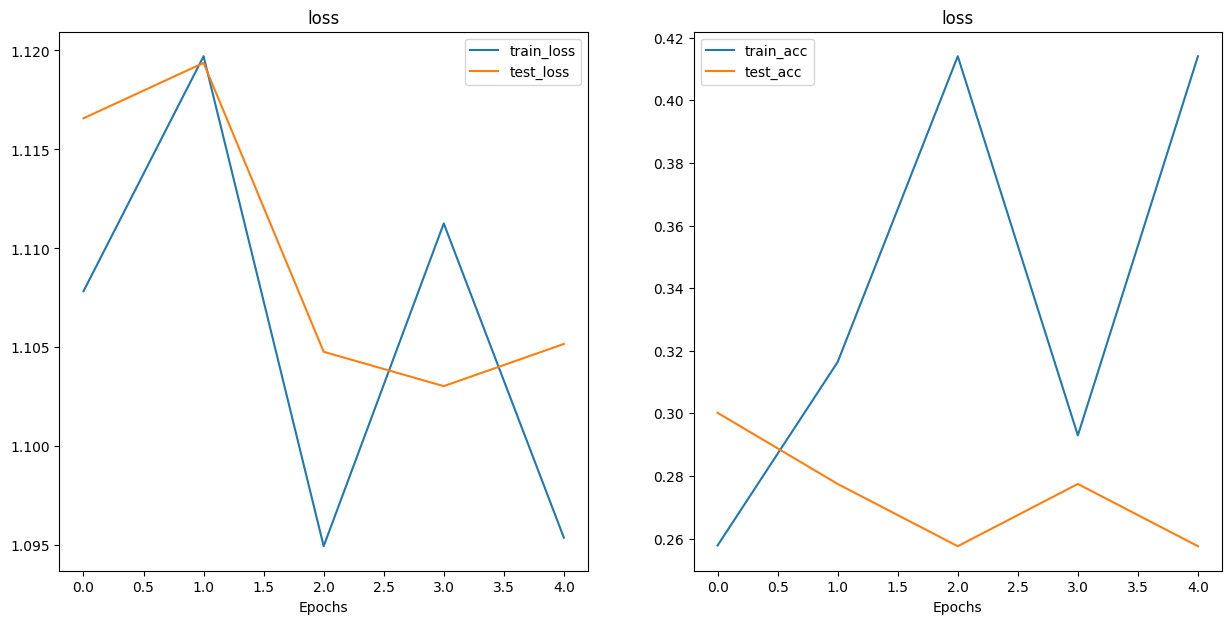

In [49]:
plot_loss(model_0_results)

In [50]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [51]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [52]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78f3bba622f0>,
 <torch.utils.data.dataloader.DataLoader at 0x78f3bc4beec0>)

In [53]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [54]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1075 | train_acc: 0.2500 | test_loss: 1.1056 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1381 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1690 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1283 | train_acc: 0.3047 | test_loss: 1.1598 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0887 | train_acc: 0.4258 | test_loss: 1.1459 | test_acc: 0.2604
Total training time: 3.407 seconds


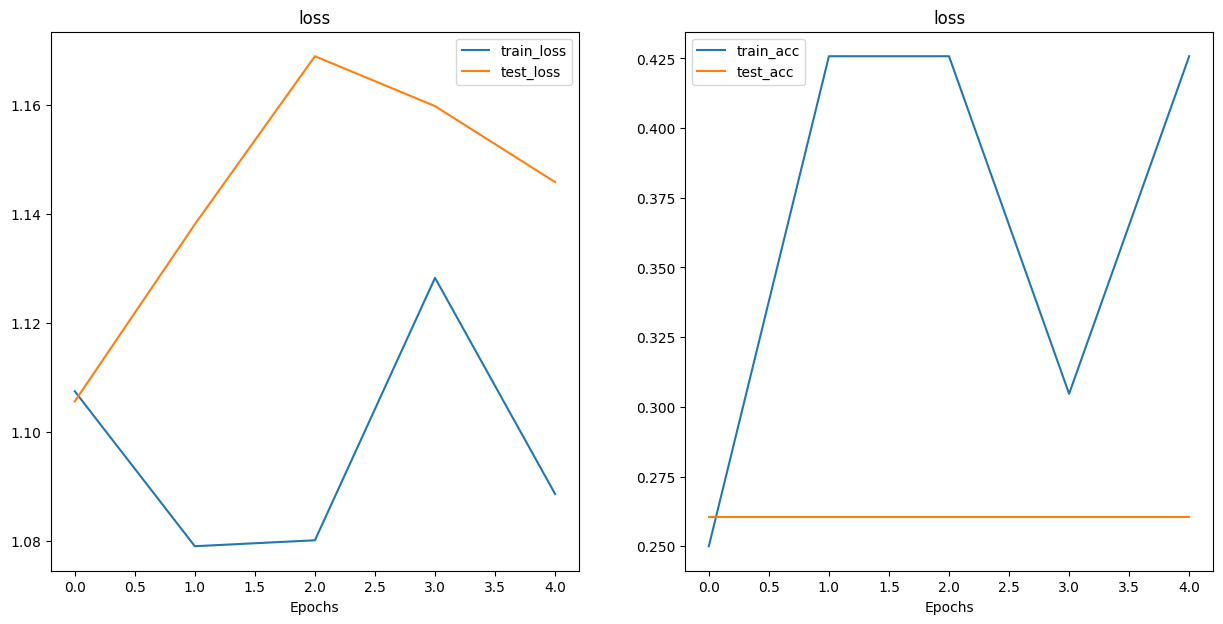

In [55]:
plot_loss(model_1_results)

In [56]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [57]:
#read_image
import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image/255

(-0.5, 3023.5, 4031.5, -0.5)

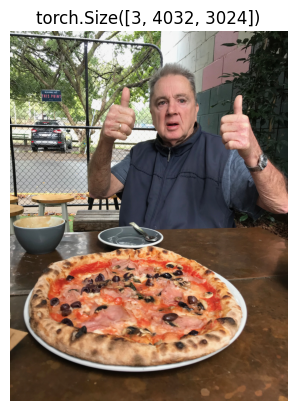

In [58]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(custom_image.shape)
plt.axis('off')

In [59]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [60]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    pred=model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [61]:
pred_soft = torch.softmax(pred,dim=1)
pred_label = torch.argmax(pred_soft,dim=1)

In [62]:
pred_label

tensor([0], device='cuda:0')

In [63]:
name = class_names[pred_label.cpu()]

In [64]:
name

'pizza'

In [65]:
def plot_pred(model,
              image_path,
              class_names=None,
              transform=None,
              device:torch.device=device):
    tg_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    tg_image = tg_image/255
    if transform: tg_image = transform(tg_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        tg_image = tg_image.unsqueeze(dim=0)
        tg_image_pred = model(tg_image.to(device))
    tg_prob = torch.softmax(tg_image_pred,dim=1)
    label = torch.argmax(tg_prob,dim=1)
    plt.imshow(tg_image.squeeze().permute(1,2,0))
    if class_names:
        title = f'Food:{class_names[label.cpu()]} , label:{label.item()}'
    else:
        title = f'Food_label:{label.item()}, Prob:{tg_prob.max().cpu():.3f}'
    plt.title(title)
    plt.axis('off')
        

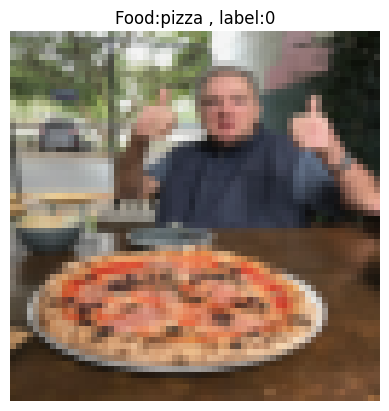

In [66]:
plot_pred(model=model_1,
          image_path=custom_image_path,
          class_names=class_names,
          transform=custom_image_transform,
          device=device)